In [1]:
import math
import os
import random
from PIL import Image
from timeit import default_timer

In [2]:
############################################################################
########################----Pixel Class----#################################
############################################################################
class Pixel:
    """
        Always setup static variables: 'is_a_star', 'target'
    """
    is_a_star = False  # False -> Best First Search, True-> A*
    target = (5, 7)  # Target to which we calculate the Heuristic Function

    def __init__(self, x, y, color, parent_cost):
        self.x = x
        self.y = y
        self.color = color
        self.cost = parent_cost + Pixel.get_pixel_cost(color)

    # Evaluating Pixel Values

    def h(self):
        """ Heuristic Function"""
        return Pixel.euclidean_distance(self.x, self.y, Pixel.target[0], Pixel.target[1])

    def g(self):
        """ Cost Function"""
        return self.cost

    def f(self):
        if not Pixel.is_a_star:
            return self.h()  # -> Best First Search
        return self.h() + self.g()  # -> A *

    # Comparing Pixels

    def __lt__(self, other):
        return self.f() < other.f()

    def __le__(self, other):
        return self.f() <= other.f()

    def __gt__(self, other):
        return self.f() > other.f()

    def __ge__(self, other):
        return self.f() >= other.f()

    def __eq__(self, other):
        return self.f() == other.f()

    def __ne__(self, other):
        return self.f() != other.f()

    # Printing Pixels

    def __repr__(self):
        return f"(x={self.x},y={self.y},color={self.color}, g()={self.cost}, h()={self.h()}, f()={self.f()})"

    def __str__(self):
        return f"(x={self.x},y={self.y},color={self.color}, g()={self.cost}, h()={self.h()}, f()={self.f()})"

    # Utility Methods

    @staticmethod
    def get_pixel_cost(color):
        if color[0] == 0:
            return 1
        return 1 / (color[0])  # Reverse of the 'red' in RGB

    @staticmethod
    def euclidean_distance(x1, y1, x2, y2):
        return math.sqrt((x1  - x2) ** 2 + (y1 - y2) ** 2)
    
    @staticmethod
    def manhattan_distance(x1, y1, x2, y2):
        return abs(x1 - x2) + abs(y1 - y2)

In [3]:
############################################################################
########################----PriorityQueue Class----#########################
############################################################################
class PriorityQueue:

    def __init__(self, initial_elements: list, comparator, max_redundant_element_count=100):
        self.comparator = comparator
        self.max_redundant_element_count = max_redundant_element_count  # See delete method
        self.heap = self.heapify(initial_elements)
        self.length = len(self.heap)
        self.max_queue_size_seen = -1
        self.number_of_deletions = 0

    def heapify(self, elements: list):
        """
        Takes list of elements, returns Heap
        Complexity: O(n)
        """

        if not elements:  # If elements is empty
            return []  # return empty list as heap

        last_index = len(elements) - 1  # Get Last Element's index
        parent_of_last_index = (last_index - 1) // 2  # Get Last Element's Parent's index
        # After last parent the tree, there is no subtree to adjust
        for i in range(parent_of_last_index, -1, -1):
            # Starting from last parent, assuming the given 'i' as the root of the subtree, down_heap
            self.down_heap(elements, len(elements), root_index=i)
        return elements  # Return the heap

    def insert(self, x):
        """
         Complexity: O(logN)
        """
        i = self.length  # index of the x
        parent_i = (i - 1) // 2  # index of x's parent

        self.heap.append(x)  # Insert x into its index
        self.length += 1
        if self.max_queue_size_seen < self.length:
            self.max_queue_size_seen = self.length

        while i > 0 and self.comparator(x, self.heap[parent_i]):
            self.heap[i] = self.heap[parent_i]  # put the parent into x's place
            i = parent_i  # Update x's index, hypothetically x is there
            parent_i = (i - 1) // 2  # Calculate x's new parent's index
        self.heap[i] = x  # Insert x into its real place

    def delete(self):
        """
        Complexity = O(logN)
        """

        deleted_element = self.heap[0]  # Delete the root by taking and putting last el into its place
        self.heap[0] = self.heap[self.length - 1]  # Put the last element into root of the tree
        self.down_heap(self.heap, length=self.length)  # Adjust the tree so that it becomes heap again
        self.length -= 1  # Exclude last element since it is no longer inside the heap
        self.number_of_deletions += 1
        # If list grows so much, deallocate the unnecessary space
        actual_length = len(self.heap)
        if (actual_length - self.length) > self.max_redundant_element_count:
            self.heap = self.heap[:self.length]

        return deleted_element

    def is_empty(self):
        return self.length == 0

    def down_heap(self, heap: list, length, root_index=0):
        i = root_index  # Start from given subtrees root
        max_child = self.get_max_priority_child_index(heap, length, i)  # Get max priority child's index
        while (max_child is not None) and self.comparator(heap[max_child], heap[i]):
            # while child exists and child greater than parent, swap them
            heap[i], heap[max_child] = heap[max_child], heap[i]  # Swap
            i = max_child  # Update node's index
            max_child = self.get_max_priority_child_index(heap, length, i)

    def get_max_priority_child_index(self, heap, length, index):
        last_index = length - 1
        if last_index < (index * 2 + 1):  # No child
            return None
        elif last_index < (index * 2 + 2):  # Only Left Child exists
            return index * 2 + 1
        else:  # Both children exists
            if self.comparator(heap[index * 2 + 1], heap[index * 2 + 2]):
                return index * 2 + 1  # Return Left Child as Max Priority child
            else:
                return index * 2 + 2  # Return Right Child as Max Priority child

    def __repr__(self):
        result = "[\n"
        for i in range(0, self.length):
            result += str(i) + ":" + str(self.heap[i]) + "\n"
        result += "]"
        return result

    def __str__(self):
        result = "[\n"
        for i in range(0, self.length):
            result += str(i) + ":" + str(self.heap[i]) + "\n"
        result += "]"
        return result

In [4]:
############################################################################
########################----Queue Class----#################################
############################################################################
class Queue:

    def __init__(self, capacity=100):
        self.internal_list = [None] * capacity
        self.capacity = capacity
        self.front = 0
        self.rear = capacity - 1
        self.size = 0
        self.max_queue_size_seen = -1
        self.number_of_deletions = 0

    def insert(self, x):
        if self.is_full():
            print("Queue is Full!")
            return

        self.rear = (self.rear + 1) % self.capacity
        self.internal_list[self.rear] = x
        self.size += 1

        if self.size > self.max_queue_size_seen:
            self.max_queue_size_seen = self.size

    def delete(self):
        if self.is_empty():
            print("Queue is Empty!")
            return None

        deleted_item = self.internal_list[self.front]
        self.front = (self.front + 1) % self.capacity
        self.size -= 1
        self.number_of_deletions += 1
        return deleted_item

    def is_empty(self):
        return self.size == 0

    def is_full(self):
        return self.capacity == self.size

    def sort(self):
        """ Using Insertion Sort """
        for i in range(self.front + 1, self.rear + 1):
            temp = self.internal_list[i]
            j = i - 1

            while j >= self.front and self.internal_list[j] > temp:
                self.internal_list[j + 1] = self.internal_list[j]
                j -= 1
            self.internal_list[j + 1] = temp

    def __repr__(self):
        result = "[\n"
        for i in range(self.front, self.rear + 1):
            result += str(i) + ":" + str(self.internal_list[i]) + "\n"
        result += "]"
        return result

    def __str__(self):
        result = "[\n"
        for i in range(self.front, self.rear + 1):
            result += str(i) + ":" + str(self.internal_list[i]) + "\n"
        result += "]"
        return result

In [5]:
############################################################################
######################---- Image Path Finder Class ----#####################
############################################################################
class ImagePathFinder:

    def __init__(self, image:Image, start, target ):
        """ @param image should never be None"""
        self.image = image
        self.width, self.height = image.size
        self.target = target
        self.start = start

    def save_image(self, image = None, location=f'C:/Users/Yukawa/AI/', name="rainbow_result", extension=".jpg"):
        if image is None:
            image = self.image
        image.save(location + name + extension)

    def insert_pixel(self, queue, image_pixels, x, y, parent_cost):
        if 0 <= x < self.width and 0 <= y < self.height:                                # If valid pixel
            queue.insert(Pixel(x, y, color=image_pixels[x,y], parent_cost=parent_cost))  # insert the pixel

    ### Path Finding Algorithms
    def find_path(self, is_a_star = True, use_priority_queue = True, image_folder_to_save=f'C:/Users/Yukawa/AI/', image_name_to_save="default"):
        """
        Finds path between start and target and paints it as white
        :param is_a_star:  if True then A* algorithm, otherwise Best First Search Algorithm
        :param use_priority_queue: if True then use Heap based Priority Queue, otherwise use List based Queue
        :param image_folder_to_save: The folder that we will be putting the images into
        :param image_name_to_save: Name of the image file to be saved
        :return: Max Queue Size ever expanded, Max Number of Deletions From the Queue
        """
        if self.image is None:
            return None

        # Work on copy of the 'self.image'
        image = self.image.copy()
        pixels = image.load()
        # Set the start Pixel
        start = Pixel(x=self.start[0], y=self.start[1], color=pixels[self.start[0], self.start[1]], parent_cost=0)
        # Configure Function Type
        Pixel.is_a_star = is_a_star  # A*:True-> f=g()+h()   Best First Search:False -> f=h()
        # Configure h() in Pixel
        Pixel.target = (self.target[0], self.target[1])  # Target to which we calculate h()

        # Setup Queue with first element
        if use_priority_queue:
            queue = PriorityQueue([start], lambda a, b: a < b)  # Min Priority Queue
        else:
            queue = Queue(capacity=50_000)
            queue.insert(start)

        # Loop infinitely unless queue becomes empty
        while (queue.is_empty() == False) and True:
            # Remove min f() element from queue
            pixel = queue.delete()
            x = pixel.x
            y = pixel.y
            # paint the point as a way of showing we've visited this pixel
            pixels[x, y] = (255, 255, 255)
            # If current pixel is the target, then the path has found
            if x == self.target[0] and y == self.target[1]:
                self.save_image(image=image, name=image_name_to_save)
                return queue.max_queue_size_seen, queue.number_of_deletions
            # Insert Neighbours
            self.insert_pixel(queue, image_pixels=pixels, x=x+1, y=y, parent_cost=pixel.cost)
            self.insert_pixel(queue, image_pixels=pixels, x=x, y=y+1, parent_cost=pixel.cost)
            self.insert_pixel(queue, image_pixels=pixels, x=x-1, y=y, parent_cost=pixel.cost)
            self.insert_pixel(queue, image_pixels=pixels, x=x, y=y-1, parent_cost=pixel.cost)

            if not use_priority_queue:
                # Sort the Queue so that first element becomes lowest cost, highest priority
                queue.sort()

    def run_4_algorithms(self, folder_to_save_images, image_name_suffix):
        # Best First Search With Heap Priority Queue
        start_dt = default_timer()
        max_size1, n_deletions1 = self.find_path(is_a_star=False, use_priority_queue=True,
                                    image_folder_to_save=folder_to_save_images, image_name_to_save=f"bfs{image_name_suffix}")
        runtime1 = default_timer() - start_dt  # in seconds

        # Best First Search With Queue(using List)
        start_dt = default_timer()
        max_size2, n_deletions2 = self.find_path(is_a_star=False, use_priority_queue=False,
                                    image_folder_to_save=folder_to_save_images, image_name_to_save=f"bfs{image_name_suffix}_2")
        runtime2 = default_timer() - start_dt  # in seconds

        # A* with Heap Priority Queue
        start_dt = default_timer()
        max_size3, n_deletions3 = self.find_path(is_a_star=True, use_priority_queue=True,
                                    image_folder_to_save=folder_to_save_images, image_name_to_save=f"a_star{image_name_suffix}")
        runtime3 = default_timer() - start_dt  # in seconds

        # A* with Queue(using List)
        start_dt = default_timer()
        max_size4, n_deletions4 = self.find_path(is_a_star=True, use_priority_queue=False,
                                    image_folder_to_save=folder_to_save_images, image_name_to_save=f"a_star{image_name_suffix}_2")
        runtime4 = default_timer() - start_dt  # in seconds

        return { "runtime":(runtime1, runtime2, runtime3, runtime4),
                 "max_size":(max_size1, max_size2, max_size3, max_size4),
                 "n_deletions":(n_deletions1, n_deletions2, n_deletions3, n_deletions4) }

    @staticmethod
    def print_run4algorithm_results(data, start, target):
        runtime = data['runtime']
        max_size = data['max_size']
        n_deletions = data['n_deletions']

        print(f"Start({start[0]},{start[1]}) Target({target[0]},{target[1]})\n"
              f"Max Size Seen: BFS:{max_size[0]}, BFS_2:{max_size[1]}, A*:{max_size[2]}, A*_2:{max_size[3]}\n"
              f"Number of Deletions: BFS:{n_deletions[0]}, BFS_2:{n_deletions[1]}, A*:{n_deletions[2]}, A*_2:{n_deletions[3]}\n"
              f"Runtime(in seconds):\n\tBFS:{runtime[0]:.2f}, BFS_2={runtime[1]:.2f}, A*={runtime[2]:.2f}, A*_2={runtime[3]:.2f}")

    @staticmethod
    def analise(image, folder_to_save_images, n=10):
        """
        !! Image must have size greater than 1000x1000
        For random 'n' number of random points, run the 4 algorithms
        @:returns list of data dictionary
        """

        print(f"\nAnalysis For {n} Random Points\n")
        width, height = image.size

        # For 10 Image
        data_list = list()

        for i in range(n):
            start = (random.randint(0, width), random.randint(0, height))
            target = (random.randint(0, width), random.randint(0, height))
            data = ImagePathFinder(image, start=start, target=target).run_4_algorithms(
                folder_to_save_images=folder_to_save_images, image_name_suffix=i)
            print("\n")
            ImagePathFinder.print_run4algorithm_results(data,start,target)
            data_list.append( (start, target, data) )
        return data_list


## Main Function

In [6]:
##### Take Image
valid_image_taken = False
while not valid_image_taken:
    try:
        input_image_path = input("Image Path: ")
        valid_image_taken = True
    except FileNotFoundError:
        print("Image Not Found! ::: Please Give Valid Image Path.")

image = Image.open(input_image_path, 'r')
width, height = image.size

#### Take Location to save Images
valid_path_taken = False
folder_to_save_images = ""
while not valid_path_taken:
    folder_to_save_images = input("Folder To Save Images: ")
    if os.path.isdir(folder_to_save_images):
        valid_path_taken = True
    else:
        print("Folder not found! :: Please Give Valid Folder To Save Images.")


##### Take Start Coordinate
print(f"Image Width: {width}, Image Height: {height}")
valid_coordinates_taken = False
start_x, start_y = -1,-1
while not valid_coordinates_taken:
    start_x, start_y = map(int, input("Start(x,y for example-> 3,4):").split(','))
    if 0 <= start_x < width and 0 <= start_y < height:
        valid_coordinates_taken = True
    else:
        print(f"Invalid Coordinates: (x={start_x},y={start_y}) is out of image size({width},{height})")

##### Take Target Coordinate
valid_coordinates_taken = False
target_x, target_y = -1,-1
while not valid_coordinates_taken:
    target_x, target_y = map(int, input("Target(x,y for example-> 9,7):").split(','))
    if 0 <= target_x < width and 0 <= target_y < height:
        valid_coordinates_taken = True
    else:
        print(f"Invalid Coordinates: (x={target_x},y={target_y}) is out of image size({width},{height})")

Image Path: C:/Users/Yukawa/AI/rainbow.jpg
Folder To Save Images: C:/Users/Yukawa/AI/
Image Width: 1920, Image Height: 1200
Start(x,y for example-> 3,4):5,7
Target(x,y for example-> 9,7):453,689


### Run For User Input

In [7]:
#### Create Image Path Finder
image_path_finder = ImagePathFinder(image.copy(),
                                    start = (start_x, start_y),
                                    target= (target_x,target_y))

print(f"\nInitial Configurations: Start:({start_x},{start_y}) ::: Target:({target_x},{target_y})")

data = image_path_finder.run_4_algorithms(folder_to_save_images=folder_to_save_images, image_name_suffix="_m_")
ImagePathFinder.print_run4algorithm_results(data,(start_x,start_y),(target_x,target_y))


Initial Configurations: Start:(5,7) ::: Target:(453,689)
Start(5,7) Target(453,689)
Max Size Seen: BFS:3391, BFS_2:3391, A*:3397, A*_2:3397
Number of Deletions: BFS:1131, BFS_2:1131, A*:1133, A*_2:1133
Runtime(in seconds):
	BFS:0.22, BFS_2=25.24, A*=0.23, A*_2=28.96


### Run 10 Times to Analize 

In [8]:
data_for_analysis = ImagePathFinder.analise(image,folder_to_save_images,10)


Analysis For 10 Random Points



Start(609,443) Target(870,504)
Max Size Seen: BFS:967, BFS_2:967, A*:967, A*_2:967
Number of Deletions: BFS:323, BFS_2:323, A*:323, A*_2:323
Runtime(in seconds):
	BFS:0.09, BFS_2=2.05, A*=0.09, A*_2=2.25


Start(1209,760) Target(1124,48)
Max Size Seen: BFS:2392, BFS_2:2392, A*:2392, A*_2:2392
Number of Deletions: BFS:798, BFS_2:798, A*:798, A*_2:798
Runtime(in seconds):
	BFS:0.17, BFS_2=11.73, A*=0.20, A*_2=12.97


Start(429,505) Target(810,627)
Max Size Seen: BFS:1510, BFS_2:1510, A*:1510, A*_2:1510
Number of Deletions: BFS:504, BFS_2:504, A*:504, A*_2:504
Runtime(in seconds):
	BFS:0.12, BFS_2=4.96, A*=0.12, A*_2=6.29


Start(1463,250) Target(1380,233)
Max Size Seen: BFS:301, BFS_2:301, A*:301, A*_2:301
Number of Deletions: BFS:101, BFS_2:101, A*:101, A*_2:101
Runtime(in seconds):
	BFS:0.06, BFS_2=0.23, A*=0.06, A*_2=0.25


Start(967,537) Target(1682,642)
Max Size Seen: BFS:2461, BFS_2:2461, A*:2461, A*_2:2461
Number of Deletions: BFS:821, BFS_2:821, 

In [9]:
data_for_analysis

[((609, 443),
  (870, 504),
  {'runtime': (0.09189130000000034,
    2.0540665000000047,
    0.09289909999999679,
    2.2458771999999954),
   'max_size': (967, 967, 967, 967),
   'n_deletions': (323, 323, 323, 323)}),
 ((1209, 760),
  (1124, 48),
  {'runtime': (0.1685837999999933,
    11.726730900000007,
    0.19651770000000113,
    12.969555899999989),
   'max_size': (2392, 2392, 2392, 2392),
   'n_deletions': (798, 798, 798, 798)}),
 ((429, 505),
  (810, 627),
  {'runtime': (0.11705560000000048,
    4.960030599999982,
    0.12134650000001557,
    6.293181000000004),
   'max_size': (1510, 1510, 1510, 1510),
   'n_deletions': (504, 504, 504, 504)}),
 ((1463, 250),
  (1380, 233),
  {'runtime': (0.06087690000001089,
    0.2329531999999972,
    0.06250330000000304,
    0.2518843000000004),
   'max_size': (301, 301, 301, 301),
   'n_deletions': (101, 101, 101, 101)}),
 ((967, 537),
  (1682, 642),
  {'runtime': (0.17032820000000015,
    13.40777970000002,
    0.17617250000000695,
    15.5383

## Analysis

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

### Distance vs Runtime

In [11]:
result_list = list()
for i in range(10):
    # calculate distance
    start = data_for_analysis[i][0]
    target = data_for_analysis[i][1]
    distance = Pixel.manhattan_distance(start[0],start[1],target[0],target[1])
    # get runtime of each run of the algorithm
    runtime = data_for_analysis[i][2]['runtime']
    # insert into result
    result_list.append( (distance,runtime[0], runtime[1], runtime[2], runtime[3]) )
    
df = pd.DataFrame(result_list)
df.index.name = 'Run'
df.columns = ['distance', 'BFS', 'BFS_2', 'A*', 'A*_2']
df.sort_values('distance', inplace=True, ascending=True)

In [12]:
df

,distance,BFS,BFS_2,A*,A*_2
Run,,,,,
3,100,0.060877,0.232953,0.062503,0.251884
6,243,0.077636,1.232186,0.080268,1.402163
0,322,0.091891,2.054067,0.092899,2.245877
2,503,0.117056,4.960031,0.121347,6.293181
1,797,0.168584,11.726731,0.196518,12.969556
4,820,0.170328,13.407780,0.176173,15.538302
7,1068,0.208162,25.781684,0.257596,28.247614
5,1286,0.267916,34.669003,0.369713,37.254902
9,1994,0.439952,79.620820,0.433343,83.606843


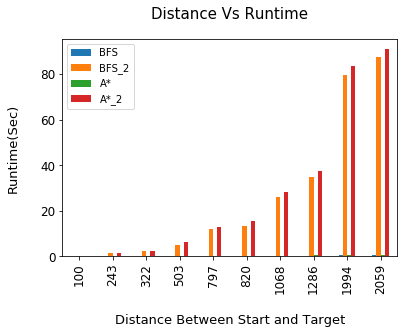

In [13]:
ax = df.plot(x='distance', kind='bar', legend=True, fontsize=12)
ax.set_xlabel("Distance Between Start and Target", labelpad=20, fontsize=13)
ax.set_ylabel("Runtime(Sec)", labelpad=20, fontsize=13)
ax.set_title("Distance Vs Runtime", pad=20,fontsize=15)
plt.show()

<font color=darkblue>**PLOT#1**:Distance Vs Runtime </font><br/>
<font color=green>**INSIGHT#1**: As distance between start and target increase,the runtime of the algorithms that have been implemented using array based queue(BFS_2, A<span>*</span>_2) outweigh the runtime of the algorithms that have been implemented using heap based priority queue(BFS,A<span>*</span>) </font><br/>
<font color=green>**INSIGHT#1.1**: The runtime of the algorithms that have been implemented using array based queue(BFS_2, A<span>*</span>_2) is so inefficient in compared to the the algorithms that have been implemented using heap based priority queue(BFS,A<span>*</span>) </font>

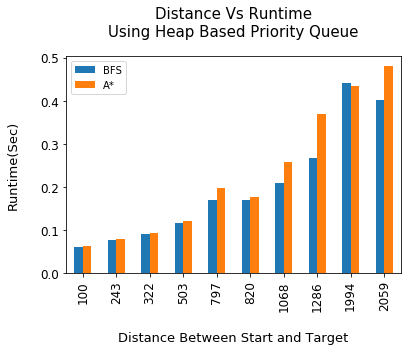

In [14]:
ax = df[['distance','BFS','A*']].plot(x='distance', kind='bar', legend=True, fontsize=12)
ax.set_xlabel("Distance Between Start and Target", labelpad=20, fontsize=13)
ax.set_ylabel("Runtime(Sec)", labelpad=20, fontsize=13)
ax.set_title("Distance Vs Runtime\nUsing Heap Based Priority Queue", pad=20,fontsize=15)
plt.show()

<font color=darkblue>**PLOT#2**:Distance Vs Runtime Using Heap Based Priority Queue </font><br/>
<font color=green>**INSIGHT#2**: As distance between start and target increase, the runtime increases linearly<br/> For Example when distance goes frm 365 to 1700 (approximately 5 fold), runtime also increases 5 fold</font>

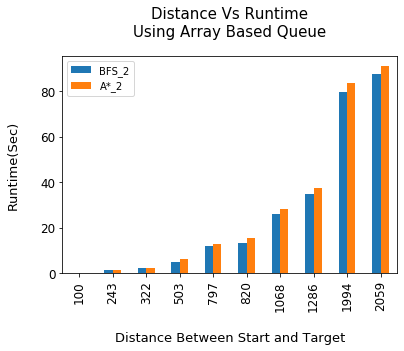

In [15]:
ax = df[['distance','BFS_2','A*_2']].plot(x='distance', kind='bar', legend=True, fontsize=12)
ax.set_xlabel("Distance Between Start and Target", labelpad=20, fontsize=13)
ax.set_ylabel("Runtime(Sec)", labelpad=20, fontsize=13)
ax.set_title("Distance Vs Runtime\nUsing Array Based Queue", pad=20,fontsize=15)
plt.show()

<font color=darkblue>**PLOT#2**:Distance Vs Runtime Using Array Based Queue </font><br/>
<font color=green>**INSIGHT#2**: As distance between start and target increase, the runtime increases non-linearly<br/> For Example when distance goes frm 785 to 2171 (approximately 3 fold), the runtime has increased 5 fold(hard to say any relation in between them)</font>

### Max Queue Size Vs Runtime

In [16]:
result_list = list()
for i in range(10):
    # get max size of queue
    max_size = data_for_analysis[i][2]['max_size'][0]
    # get runtime of each run of the algorithm
    runtime = data_for_analysis[i][2]['runtime']
    # insert into result
    result_list.append( (max_size, runtime[0], runtime[1], runtime[2], runtime[3]) )
    
df = pd.DataFrame(result_list)
df.index.name = 'Run'
df.columns = ['max_size', 'BFS', 'BFS_2', 'A*', 'A*_2']
df.sort_values('max_size', inplace=True, ascending=True)

In [17]:
df

,max_size,BFS,BFS_2,A*,A*_2
Run,,,,,
3,301,0.060877,0.232953,0.062503,0.251884
6,730,0.077636,1.232186,0.080268,1.402163
0,967,0.091891,2.054067,0.092899,2.245877
2,1510,0.117056,4.960031,0.121347,6.293181
1,2392,0.168584,11.726731,0.196518,12.969556
4,2461,0.170328,13.407780,0.176173,15.538302
7,3205,0.208162,25.781684,0.257596,28.247614
5,3859,0.267916,34.669003,0.369713,37.254902
9,5983,0.439952,79.620820,0.433343,83.606843


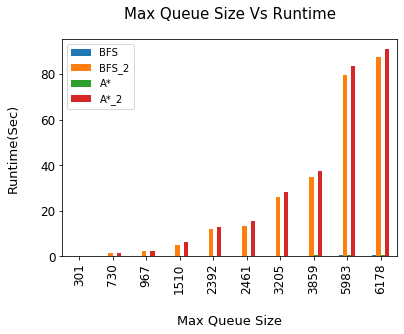

In [18]:
ax = df.plot(x='max_size', kind='bar', legend=True, fontsize=12)
ax.set_xlabel("Max Queue Size", labelpad=20, fontsize=13)
ax.set_ylabel("Runtime(Sec)", labelpad=20, fontsize=13)
ax.set_title("Max Queue Size Vs Runtime", pad=20,fontsize=15)
plt.show()

<font color=darkblue>**PLOT#3**:Max Queue Size Vs Runtime</font><br/>
<font color=green>**INSIGHT#3**: As maximum queue size increase, runtime of the algorithms that have been implemented using array based queue becomes so inefficient</font>

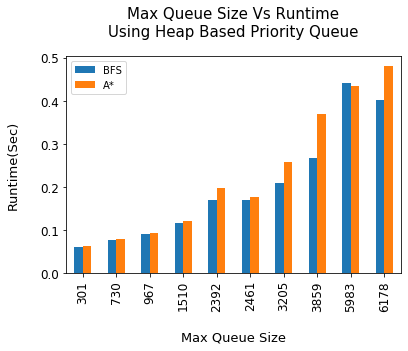

In [19]:
ax = df[['max_size','BFS','A*']].plot(x='max_size', kind='bar', legend=True, fontsize=12)
ax.set_xlabel("Max Queue Size", labelpad=20, fontsize=13)
ax.set_ylabel("Runtime(Sec)", labelpad=20, fontsize=13)
ax.set_title("Max Queue Size Vs Runtime\nUsing Heap Based Priority Queue", pad=20,fontsize=15)
plt.show()

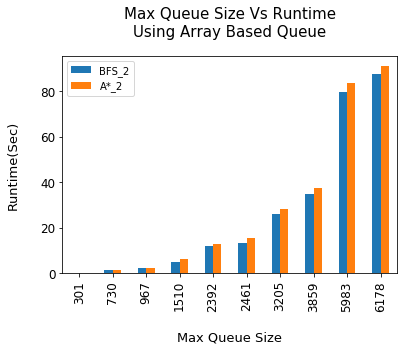

In [20]:
ax = df[['max_size','BFS_2','A*_2']].plot(x='max_size', kind='bar', legend=True, fontsize=12)
ax.set_xlabel("Max Queue Size", labelpad=20, fontsize=13)
ax.set_ylabel("Runtime(Sec)", labelpad=20, fontsize=13)
ax.set_title("Max Queue Size Vs Runtime\nUsing Array Based Queue", pad=20,fontsize=15)
plt.show()

### Number of Deletions Vs Runtime

In [21]:
result_list = list()
for i in range(10):
    # get number of deletions
    n_deletions = data_for_analysis[i][2]['n_deletions'][0]
    # get runtime of each run of the algorithm
    runtime = data_for_analysis[i][2]['runtime']
    # insert into result
    result_list.append( (n_deletions, runtime[0], runtime[1], runtime[2], runtime[3]) )
    
df = pd.DataFrame(result_list)
df.index.name = 'Run'
df.columns = ['n_deletions', 'BFS', 'BFS_2', 'A*', 'A*_2']
df.sort_values('n_deletions', inplace=True, ascending=True)

In [22]:
df

,n_deletions,BFS,BFS_2,A*,A*_2
Run,,,,,
3,101,0.060877,0.232953,0.062503,0.251884
6,244,0.077636,1.232186,0.080268,1.402163
0,323,0.091891,2.054067,0.092899,2.245877
2,504,0.117056,4.960031,0.121347,6.293181
1,798,0.168584,11.726731,0.196518,12.969556
4,821,0.170328,13.407780,0.176173,15.538302
7,1069,0.208162,25.781684,0.257596,28.247614
5,1287,0.267916,34.669003,0.369713,37.254902
9,1995,0.439952,79.620820,0.433343,83.606843


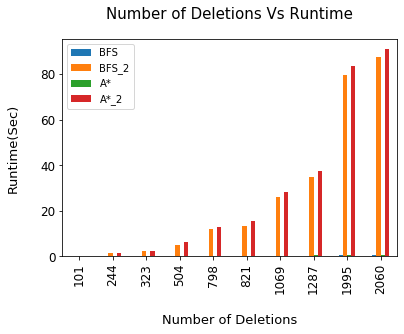

In [23]:
ax = df.plot(x='n_deletions', kind='bar', legend=True, fontsize=12)
ax.set_xlabel("Number of Deletions", labelpad=20, fontsize=13)
ax.set_ylabel("Runtime(Sec)", labelpad=20, fontsize=13)
ax.set_title("Number of Deletions Vs Runtime", pad=20,fontsize=15)
plt.show()

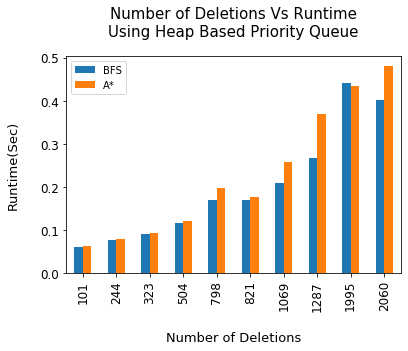

In [24]:
ax = df[['n_deletions','BFS','A*']].plot(x='n_deletions', kind='bar', legend=True, fontsize=12)
ax.set_xlabel("Number of Deletions", labelpad=20, fontsize=13)
ax.set_ylabel("Runtime(Sec)", labelpad=20, fontsize=13)
ax.set_title("Number of Deletions Vs Runtime\nUsing Heap Based Priority Queue", pad=20,fontsize=15)
plt.show()

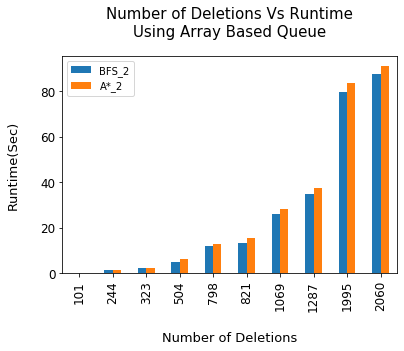

In [25]:
ax = df[['n_deletions','BFS_2','A*_2']].plot(x='n_deletions', kind='bar', legend=True, fontsize=12)
ax.set_xlabel("Number of Deletions", labelpad=20, fontsize=13)
ax.set_ylabel("Runtime(Sec)", labelpad=20, fontsize=13)
ax.set_title("Number of Deletions Vs Runtime\nUsing Array Based Queue", pad=20,fontsize=15)
plt.show()

### Distance vs Number of Deletions

In [26]:
result_list = list()
for i in range(10):
    # calculate distance
    start = data_for_analysis[i][0]
    target = data_for_analysis[i][1]
    distance = Pixel.manhattan_distance(start[0],start[1],target[0],target[1])
    # get number of deletions
    n_deletions = data_for_analysis[i][2]['n_deletions'][0]
    # insert into result
    result_list.append( (distance,n_deletions) )
    
df = pd.DataFrame(result_list)
df.index.name = 'Run'
df.columns = ['distance', 'n_deletion']

In [27]:
df

,distance,n_deletion
Run,,
0,322,323
1,797,798
2,503,504
3,100,101
4,820,821
5,1286,1287
6,243,244
7,1068,1069
8,2059,2060


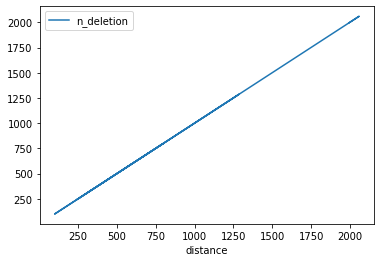

In [28]:
df.plot(x='distance', y='n_deletion')

### Distance Vs Max Queue Size

In [29]:
result_list = list()
for i in range(10):
    # calculate distance
    start = data_for_analysis[i][0]
    target = data_for_analysis[i][1]
    distance = Pixel.manhattan_distance(start[0],start[1],target[0],target[1])
    # get max queue size
    max_size = data_for_analysis[i][2]['max_size'][0]
    # insert into result
    result_list.append( (distance,max_size) )
    
df = pd.DataFrame(result_list)
df.index.name = 'Run'
df.columns = ['distance', 'max_size']

In [30]:
df

,distance,max_size
Run,,
0,322,967
1,797,2392
2,503,1510
3,100,301
4,820,2461
5,1286,3859
6,243,730
7,1068,3205
8,2059,6178


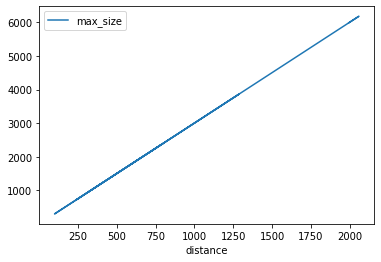

In [31]:
df.plot(x='distance', y='max_size')

### Max Queue Size Vs Number of Deletions 

In [32]:
result_list = list()
for i in range(10):
    # get max size of queue
    max_size = data_for_analysis[i][2]['max_size'][0]
    # get number of deletions
    n_deletions = data_for_analysis[i][2]['n_deletions'][0]
    # insert into result
    result_list.append( (max_size, n_deletions) )
    
df = pd.DataFrame(result_list)
df.index.name = 'Run'
df.columns = ['max_size', 'n_deletions']

In [33]:
df

,max_size,n_deletions
Run,,
0,967,323
1,2392,798
2,1510,504
3,301,101
4,2461,821
5,3859,1287
6,730,244
7,3205,1069
8,6178,2060


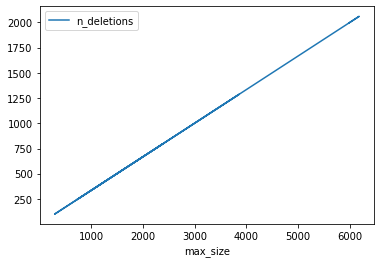

In [34]:
df.plot(x='max_size', y='n_deletions')